# Introduction

The purpose of this notebook is to dive deeper into the initialization of neural network models. In the first part of this series, we explored the concept of Generative AI and built a simple model that generates text using a bigram model and a single-layer neural network (NN). In the second part, we built a more complex model using a Multi-Layer Perceptron (MLP) to generate text.

In this study, we cover the following concepts:
- Output layer initialization
- Input layer normalization
- Batch normalization
- Data visualization techniques to understand the behavior of the model

# Data loading and cleanup

Just like in the previous part, we use a dataset containing common bird names. Our source data can be found [here](https://www.kaggle.com/datasets/thepushkarp/common-bird-names).



In [ ]:
import matplotlib.pyplot as plt
import random
import torch
import torch.nn.functional as F

In [ ]:
DATASET_PATH = "./datasets/birds/birds.csv"

birds = open(DATASET_PATH, "r").read().splitlines()

print("First 10 birds in the dataset:\n")
print(", ".join(birds[:10]))
print(f"There are {len(birds):,d} birds in the dataset.")

min_length = map(len, birds)
max_length = map(len, birds)
print(f"\nThe shortest character name has {min(min_length)} characters.")
print(f"The longest character name has {max(max_length)} characters.")

First 10 birds in the dataset:

Abbott's babbler, Abbott's booby, Abbott's starling, Abbott's sunbird, Abd al-Kuri sparrow, Abdim's stork, Aberdare cisticola, Aberrant bush warbler, Abert's towhee, Abyssinian catbird
There are 10,976 birds in the dataset.

The shortest character name has 3 characters.
The longest character name has 35 characters.


# Data Cleaning

Before we can use the bird names for training our neural network, we need to clean and standardize the data. Raw text data often contains inconsistencies that can make training more difficult, so we'll apply several preprocessing steps to ensure our dataset is uniform and ready for tokenization.

The cleaning process we'll implement includes:
- **Whitespace normalization**: Removing leading and trailing spaces
- **Case standardization**: Converting all text to lowercase for consistency
- **Character filtering**: Removing accents and special characters that might complicate tokenization
- **Space handling**: Replacing spaces with underscores to create valid single tokens
- **Tokenization mapping**: Creating bidirectional mappings between characters and numerical indices

This preprocessing step is crucial for ensuring our model receives clean, consistent input data that will lead to better training results.

In [95]:
from unidecode import unidecode

def clean_name(name):
    """
    Clean the bird name by:
    - Removing leading and trailing whitespaces
    - Converting to lowercase
    - Removing accents
    - Removing special characters
    - Replacing spaces with underscores
    """

    name = name.strip().lower()
    # replace special characters with a space
    name = ''.join(char if char.isalnum() or char.isspace() else ' ' for char in name)
    name = name.replace("`", "_")  # Remove apostrophes
    name = name.replace(" ", "_")
    name = unidecode(name)
    return name

In [96]:
# clean all names in the dataset
birds = list(map(clean_name, birds))

# create a mapping from tokens to indices
unique_tokens = set([c for w in birds for c in w])
SPECIAL_TOKEN = "."
index_to_token = {i: t for i, t in enumerate(unique_tokens, start=1)}
token_to_index = {v: k for k, v in index_to_token.items()}
index_to_token[0] = SPECIAL_TOKEN
token_to_index[SPECIAL_TOKEN] = 0

# log information about the tokenization
print(f"Number of unique tokens: {len(unique_tokens)}")
print(", ".join(sorted(unique_tokens)))
print(f"\nToken mapping: {index_to_token}")

Number of unique tokens: 28
_, `, a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z

Token mapping: {1: 'm', 2: 'l', 3: 'r', 4: 'n', 5: '`', 6: 'k', 7: 'o', 8: 'g', 9: 'c', 10: 'v', 11: 'j', 12: 'u', 13: 's', 14: 'a', 15: 'i', 16: 'e', 17: 'w', 18: 'q', 19: '_', 20: 'b', 21: 'h', 22: 'y', 23: 't', 24: 'z', 25: 'p', 26: 'x', 27: 'f', 28: 'd', 0: '.'}


# Modeling Datasets

In this section, we divide the dataset into training, validation, and test sets. We will use the validation set to tune the model and the test set to evaluate the model.

We will use 80% of the data for training, 10% for validation, and 10% for testing.

In [97]:
# Model parameters
CONTEXT_SIZE = 3
N_EMBEDDINGS = 10
N_HIDDEN = 200

# Training parameters
TRAINING_SET_PORTION = 0.8
DEVELOPMENT_SET_PORTION = 0.1
TEST_SET_PORTION = 1 - (TRAINING_SET_PORTION + DEVELOPMENT_SET_PORTION)


In [98]:
def build_datasets(words: list[str]) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Build datasets from a list of words by creating input and target tensors.
    
    Args:
        words (list[str]): List of words to build the datasets from.
        
    Returns:
        tuple[torch.Tensor, torch.Tensor]: Tuple containing the input tensor X and target tensor Y.
    """
    # Create a mapping from tokens to indices
    X, Y = [], []
    
    # Create the context for each character in the words
    for w in words:
        context = [0] * CONTEXT_SIZE
        for ch in w + SPECIAL_TOKEN:  # Add special token at the end
            ix = token_to_index[ch]
            X.append(context)
            Y.append(ix)
            # Update the context by shifting it and adding the new index 
            context = context[1:] + [ix]

    # Convert lists to tensors
    X = torch.tensor(X, dtype=torch.int64)
    Y = torch.tensor(Y, dtype=torch.int64)

    return X, Y
    
# Shuffle the words
random.seed(1234)
random.shuffle(birds)

# Split the dataset into training, development, and test sets
train_size = int(TRAINING_SET_PORTION * len(birds))
dev_size = int(DEVELOPMENT_SET_PORTION * len(birds))

X_train, Y_train = build_datasets(birds[:train_size])
X_dev, Y_dev = build_datasets(birds[train_size:train_size + dev_size])
X_test, Y_test = build_datasets(birds[train_size + dev_size:])

# print tensor shapes
print("Training set shape:", X_train.shape, Y_train.shape)
print("Development set shape:", X_dev.shape, Y_dev.shape)
print("Test set shape:", X_test.shape, Y_test.shape)

Training set shape: torch.Size([172513, 3]) torch.Size([172513])
Development set shape: torch.Size([21531, 3]) torch.Size([21531])
Test set shape: torch.Size([21461, 3]) torch.Size([21461])


# Optimizing the initialization of the model

The following code defines a simple feed-forward neural network model. It consists of an embedding layer, a hidden layer, and an output layer.

Throughout this notebook, we investigate the effects of different initialization strategies. This function allows for several approaches to be tested by adjusting the `W_scale` and `b_scale` parameters.

1. Reduce the variance of the weights and biases to avoid a very opinionated initial softmax function.
2. Reduce the variance of the weights and biases to avoid saturation of the tanh function.

## Generic initialization function

We start with a simple initialization using a normal distribution.

### Create model architecture

In [ ]:
def create_model(embedding_dim, context_size, layer_size, n_token,
                W1_scale: float = 1.0, b1_scale: float = 1.0,
                W2_scale: float = 1.0, b2_scale: float = 1.0):
    """
    Create a simple feedforward neural network model.
    This model consists of an embedding layer, a hidden layer, and an output layer.

    Args:
        -- Model architecture --
        embedding_dim (int): Dimension of the embedding layer.
        context_size (int): Size of the context window.
        layer_size (int): Size of the hidden layer.
        n_token (int): Number of unique tokens in the vocabulary.

        -- Normalization parameters --
        W1_scale (float): Scale factor for the weights of the first layer. Default is 1.0.
        b1_scale (float): Scale factor for the biases of the first layer. Default is 1.0.
        W2_scale (float): Scale factor for the weights of the second layer. Default is 1.0.
        b2_scale (float): Scale factor for the biases of the second layer. Default is 1.0.

    Returns:
        list[torch.Tensor]: List of model parameters including embeddings, weights, and biases.
            - C (torch.Tensor): Embedding matrix of shape (n_token, embedding_dim).
            - W1 (torch.Tensor): Weights for the first layer of shape (embedding_dim * context_size, layer_size).
            - b1 (torch.Tensor): Bias for the first layer of shape (layer_size,).
            - W2 (torch.Tensor): Weights for the second layer of shape (layer_size, n_token).
            - b2 (torch.Tensor): Bias for the second layer of shape (n_token,).
            - bngain (torch.Tensor): Gain for batch normalization of shape (1, layer_size).
            - bnbias (torch.Tensor): Bias for batch normalization of shape (1, layer_size).
    """

    g = torch.Generator().manual_seed(1234)

    # Embedding matrix
    C = torch.randn((n_token, embedding_dim), dtype=torch.float32, generator=g) # shape (28, 10)

    # Hidden layer
    W1 = torch.randn((embedding_dim * context_size, layer_size), dtype=torch.float32, generator=g) * W1_scale # shape (30, 128)
    b1 = torch.randn((layer_size,), dtype=torch.float32, generator=g) * b1_scale # shape (128,)

    # Output layer
    W2 = torch.randn((layer_size, n_token), dtype=torch.float32, generator=g) * W2_scale # shape (128, 28)
    b2 = torch.randn((n_token,), dtype=torch.float32, generator=g) * b2_scale # shape (28,)

    # Batch normalization parameters
    bngain = torch.ones((1, layer_size), dtype=torch.float32)  # Gain for batch normalization
    bnbias = torch.zeros((1, layer_size), dtype=torch.float32)

    bnmean_running = torch.zeros((1, layer_size), dtype=torch.float32)  # Running mean for batch normalization 
    bnstd_running = torch.ones((1, layer_size), dtype=torch.float32)  # Running std for batch normalization

    params = [C, W1, b1, W2, b2, bngain, bnbias]

    print(f"The model has {sum(p.nelement() for p in params):,d} parameters.")

    for p in params:
        p.requires_grad = True  # Set requires_grad to True to enable backpropagation

    # Add batch normalization parameters
    params += [bnmean_running, bnstd_running]

    return params

### Training parameters

In [100]:
# Training parameters
MAX_STEPS = 200_000
BATCH_SIZE = 32
INITIAL_LEARNING_RATE = 0.1
LEARNING_RATE_DECAY = 0.1

### Model training

In [101]:
def forward(params, X, use_batch_norm: bool = False):
    """
    Forward pass through the
    neural network model.
    Args:
        params (list[torch.Tensor]): List of model parameters including embeddings, weights, and biases.
        X (torch.Tensor): Input tensor of shape (BATCH_SIZE, CONTEXT_SIZE).
        use_batch_norm (bool): If True, applies batch normalization to the hidden layer activations.
    Returns:
        torch.Tensor: Output tensor of shape (BATCH_SIZE, n_token) representing the logits.
    """

    # Unpack parameters for easier access
    C, W1, b1, W2, b2, bngain, bnbias, bnmean_running, bnstd_running = params

    # Forward pass
    with torch.no_grad():
        emb = C[X]  # shape (BATCH_SIZE, CONTEXT_SIZE, N_EMBEDDINGS)
        embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
        hpreact = embcat @ W1 + b1  # shape (BATCH_SIZE, LAYER_SIZE)
        if use_batch_norm:
            hpreact = (hpreact - bnmean_running) / bnstd_running  # Batch normalization
            # Apply gain and bias
            hpreact = bngain * hpreact + bnbias  # shape (BATCH_SIZE, LAYER_SIZE)
        h = torch.tanh(hpreact)  # shape (BATCH_SIZE, LAYER_SIZE)
        logits = h @ W2 + b2  # shape (BATCH_SIZE, n_token)

    return logits

def train_model(params, X_train, Y_train, X_dev=None, Y_dev=None, break_after_1_step=False, use_batch_norm: bool = False):
    """
    Train the model using the provided parameters and training data.
    
    Args:
        params (list[torch.Tensor]): List of model parameters including embeddings, weights, and biases.
        X_train (torch.Tensor): Input tensor for training.
        Y_train (torch.Tensor): Target tensor for training.
        X_dev (torch.Tensor, optional): Input tensor for development set. Defaults to None.
        Y_dev (torch.Tensor, optional): Target tensor for development set. Defaults to None.
        break_after_1_step (bool, optional): If True, breaks after one training step
        use_batch_norm (bool, optional): If True, applies batch normalization. Defaults to False.
        
    Returns:
        lossi (list[float]): List of loss values recorded during training.
        h (Tensor): Hidden layer activations after the last forward pass.
    """

    # Unpack parameters for easier access
    C, W1, b1, W2, b2, bngain, bnbias, bnmean_running, bnstd_running = params

    # Create a generator for reproducibility
    g = torch.Generator().manual_seed(1234)

    lossi = []

    n_steps = MAX_STEPS

    for i in range(n_steps):

        # Minibatch index
        ix = torch.randint(0, X_train.shape[0], (BATCH_SIZE,), generator=g)  # Randomly sample BATCH_SIZE indices, shape (BATCH_SIZE,)
        Xb, Yb = X_train[ix], Y_train[ix]  # Get the corresponding input and target tensors

        # Forward pass
        emb = C[Xb]  # shape (BATCH_SIZE, CONTEXT_SIZE, N_EMBEDDINGS)
        embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
        
        # Linear layer
        hpreact = embcat @ W1 + b1  # shape (BATCH_SIZE, LAYER_SIZE)

        # Batch normalization
        if use_batch_norm:
            bnmean_i = hpreact.mean(dim=0, keepdim=True).mean()  # Mean for batch normalization
            bnstd_i = hpreact.std(dim=0, keepdim=True)  # Std for batch normalization
            hpreact = (hpreact - bnmean_i) / bnstd_i  # Batch normalization
            # Apply gain and bias
            hpreact = bngain * hpreact + bnbias  # shape (BATCH_SIZE, LAYER_SIZE)

            # Update running statistics for batch normalization
            with torch.no_grad():
                bnmean_running = bnmean_running * 0.999 + bnmean_i * 0.001
                bnstd_running = bnstd_running * 0.999 + bnstd_i * 0.001

        # Activation function
        h = torch.tanh(hpreact)  # shape (BATCH_SIZE, LAYER_SIZE)

        # Output layer
        logits = h @ W2 + b2  # shape (BATCH_SIZE, n_token)
        loss = F.cross_entropy(logits, Yb)  # compute the cross-entropy loss

        # Backward pass
        for p in params:
            p.grad = None  # Reset gradients to zero before backpropagation
        loss.backward()  # Compute gradients

        # Update parameters using gradient descent
        lr = INITIAL_LEARNING_RATE if i < 100_000 else INITIAL_LEARNING_RATE * LEARNING_RATE_DECAY
        for p in params:
            if p.grad is not None:
                p.data -= lr * p.grad

        # Logging
        if i % 10_000 == 0:
            print(f"{i:8,d}/{n_steps:8,d} | Loss: {loss.item():.4f} | Learning Rate: {lr:.6f}")

        lossi.append(loss.log10().item())

        if break_after_1_step and i == 0:
            print("Breaking after one step as requested.")
            break

    if X_dev is not None and Y_dev is not None:
        # Evaluate on the development set
        with torch.no_grad():
            dev_logits = forward(params, X_dev)
            dev_loss = F.cross_entropy(dev_logits, Y_dev)
            print(f"Development Loss: {dev_loss.item():.4f}")

    return lossi, h

We create a model with random initialization of the embeddings, weights, and biases. After a single batch, we stop the training and measure the loss.

In [102]:
# Create the model without any normalization
params = create_model(N_EMBEDDINGS, CONTEXT_SIZE, N_HIDDEN, len(token_to_index))
# Train the model
lossi, h = train_model(params, X_train, Y_train, X_dev=None, Y_dev=None, break_after_1_step=True)

The model has 12,719 parameters.
       0/ 200,000 | Loss: 23.4012 | Learning Rate: 0.100000
Breaking after one step as requested.


## Initial loss fix

We see that the initial loss is very high and much higher than a random guess. In fact, a model choosing a random token would have a loss of $\log(\frac{1}{V})$, where $V$ is the vocabulary size. This is because the model would be equally likely to choose any token from the vocabulary, leading to a uniform distribution over the output logits.

In [103]:
expected_probability = 1 / len(token_to_index)
expected_loss = -torch.log(torch.tensor(expected_probability))
print(f"Expected probability for a random guess: {expected_probability:.4f}")
print(f"Expected loss for a random guess: {expected_loss.item():.4f}")

Expected probability for a random guess: 0.0345
Expected loss for a random guess: 3.3673


By reducing the amplitude of the weights of the output layer, we can reduce the initial loss. Even though this approach leaves room for trial and error to find the best initialization, it is a good starting point.

In [104]:
# Create the model and reduce the amplitude of the output layer
params = create_model(N_EMBEDDINGS, CONTEXT_SIZE, N_HIDDEN, len(token_to_index), W2_scale=0.1, b2_scale=0.0)
# Train the model
lossi, h = train_model(params, X_train, Y_train, X_dev=None, Y_dev=None, break_after_1_step=True)

The model has 12,719 parameters.
       0/ 200,000 | Loss: 3.9139 | Learning Rate: 0.100000
Breaking after one step as requested.


## Hidden layer initialization

Having most of the neurons take values close to -1 and 1 affects the gradient of the tanh function. Since $\frac{d}{dx} \tanh(x) = 1 - \tanh^2(x)$, the gradient takes values close to 0 when the input is large, which leads to vanishing gradients. This is why, initially, we do not want the values flowing through the network to be too large. As shown in the plot below, a large majority of the output values of the first layer are close to -1 or 1, which is not ideal for training.

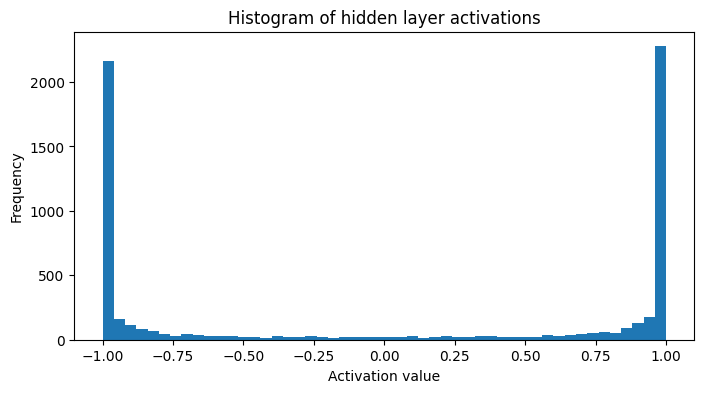

In [105]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.hist(h.view(-1).tolist(), 50)
plt.title("Histogram of hidden layer activations")
plt.xlabel("Activation value")
plt.ylabel("Frequency")
plt.show();

Another aspect to consider is the possibility of dead neurons in the network. A dead neuron is a neuron that outputs a constant value, which means it does not contribute to the learning process. This can happen if the weights are initialized in such a way that the neuron never activates. Below, we plot the output values of the first layer on the last batch.

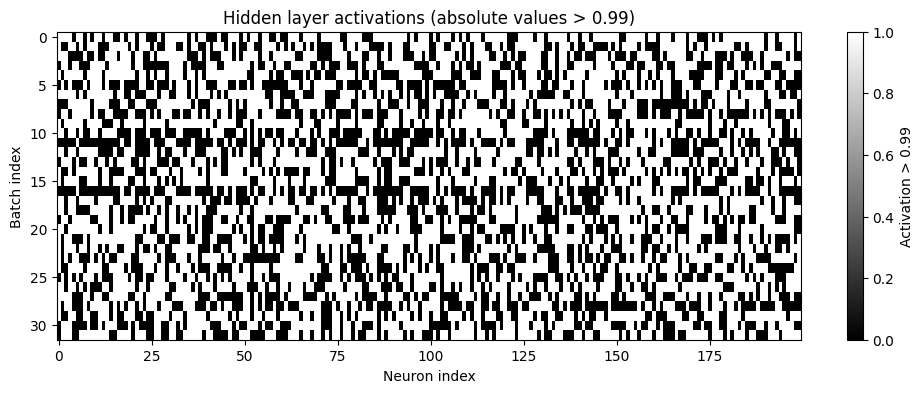

In [106]:
plt.figure(figsize=(12, 4))
plt.imshow(h.abs()>0.99, aspect='auto', cmap='gray')
plt.title("Hidden layer activations (absolute values > 0.99)")
plt.xlabel("Neuron index")
plt.ylabel("Batch index")
plt.colorbar(label="Activation > 0.99")
plt.show();

We can look for any dead neurons in the hidden layer by checking if any of the activations are zero across all batches. If a neuron is dead, it means it does not contribute to the output and can be removed from the model.

In [107]:
neuron_values = h.sum(dim=0).abs()
print(f"Minimum absolute neuron activation value: {neuron_values.min().item():.4f}")
print(f"Maximum absolute neuron activation value: {neuron_values.max().item():.4f}")

Minimum absolute neuron activation value: 0.0031
Maximum absolute neuron activation value: 25.0589


If we now reduce the variance of the weights and biases, we can see that the initial loss is much lower and the hidden layer activations are more balanced. This leads to a better training process as the gradients are more stable and the model can learn more effectively.

In [108]:
# Create the model and reduce the amplitude of the output layer and the hidden layer
params = create_model(N_EMBEDDINGS, CONTEXT_SIZE, N_HIDDEN, len(token_to_index), W2_scale=0.1, b2_scale=0.0, W1_scale=0.1, b1_scale=0.0)
# Train the model
lossi, h = train_model(params, X_train, Y_train, X_dev=None, Y_dev=None, break_after_1_step=True)

The model has 12,719 parameters.
       0/ 200,000 | Loss: 3.4889 | Learning Rate: 0.100000
Breaking after one step as requested.


The plot below shows the hidden layer activations after reducing the variance of the weights and biases. We can see that the activations are more balanced, with fewer neurons taking extreme values close to -1 or 1 and the majority of the neurons taking values ranging from -0.5 to 0.5.

In [ ]:
g = torch.Generator().manual_seed(56789)

class Linear:

    def __init__(self, fan_in, fan_out, bias=True, generator=g):
        self.weight = torch.randn(fan_in, fan_out, generator=generator) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.momentum = momentum
        self.eps = eps
        self.training = True

        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers trained with momentum
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True) # shape (1, dim)
            xvar = x.var(0, keepdim=True, unbiased=True) # shape (1, dim)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

n_emb = 10
n_hidden = 100
vocab_size = len(token_to_index)


# model initialization
C = torch.randn((vocab_size, n_emb), generator=g)
layers = [
    Linear(n_emb * CONTEXT_SIZE, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,             n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,             n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,             n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,             n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,             vocab_size)
]


with torch.no_grad():
    # shrink confidence of last layer
    layers[-1].weight *= 0.1
    # apply tanh gain to other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3


parameters = [C] + [p for layer in layers for p in layer.parameters()]

# display number of total parameters
print(f"Total number of parameters: {sum(p.nelement() for p in parameters):,}")
for p in parameters:
    p.requires_grad = True

Total number of parameters: 47,719


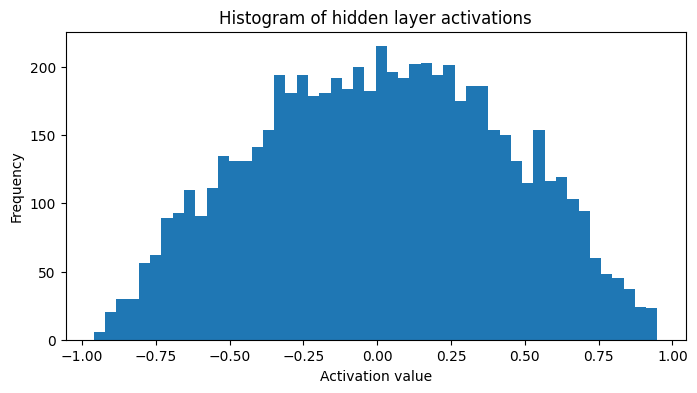

In [109]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.hist(h.view(-1).tolist(), 50)
plt.title("Histogram of hidden layer activations")
plt.xlabel("Activation value")
plt.ylabel("Frequency")
plt.show();

In [110]:
neuron_values = h.sum(dim=0).abs()
print(f"Minimum absolute neuron activation value: {neuron_values.min().item():.4f}")
print(f"Maximum absolute neuron activation value: {neuron_values.max().item():.4f}")

Minimum absolute neuron activation value: 0.0324
Maximum absolute neuron activation value: 9.9241


## Information variance growth

When chaining linear layers, the variance of the output grows. This is because the output of each layer is a linear combination of the inputs, and if the weights are not properly scaled, the output can grow very large. This can lead to saturation of the activation functions, which in turn leads to vanishing gradients.

Below is a simple example using a single matrix multiplication. We can see that the variance of the output grows with the number of layers. This is why we need to scale the weights and biases properly to avoid this issue.

x mean = 0.0059, std = 0.9911
y mean = -0.0067, std = 3.1721


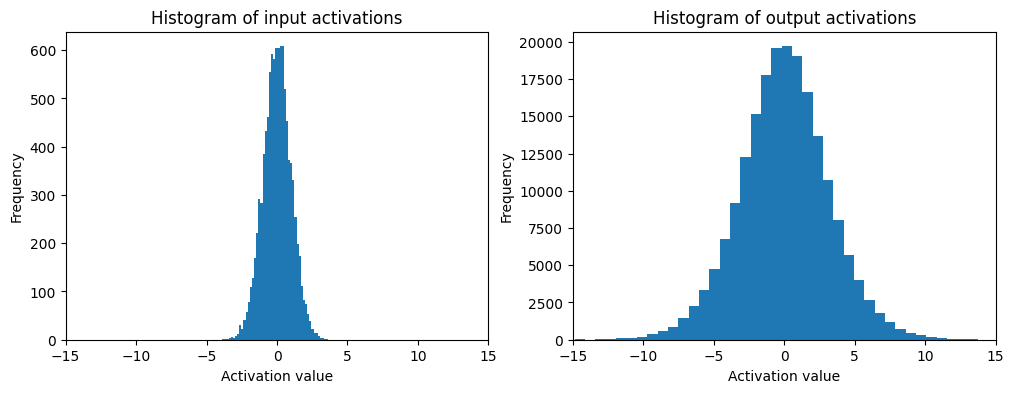

In [111]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w  # shape (1000, 200)
print(f"x mean = {x.mean().item():.4f}, std = {x.std().item():.4f}")
print(f"y mean = {y.mean().item():.4f}, std = {y.std().item():.4f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(x.view(-1).tolist(), 50)
plt.title("Histogram of input activations")
plt.xlabel("Activation value")
plt.ylabel("Frequency") 
plt.xlim(-15, 15)
plt.subplot(1, 2, 2)
plt.hist(y.view(-1).tolist(), 50)
plt.title("Histogram of output activations")
plt.xlabel("Activation value")
plt.ylabel("Frequency")
# use same scale for the x-axis
plt.xlim(-15, 15)
plt.show();


The goal is then to initialize the weights and biases in such a way that the variance of the output is controlled. If we scale the weights by a factor of $\frac{1}{\sqrt{n}}$, where $n$ is the number of inputs to the layer, we can keep the variance of the output constant across layers. This is known as Xavier initialization or Glorot initialization.

x mean = 0.0073, std = 1.0007
y mean = 0.0019, std = 1.0068


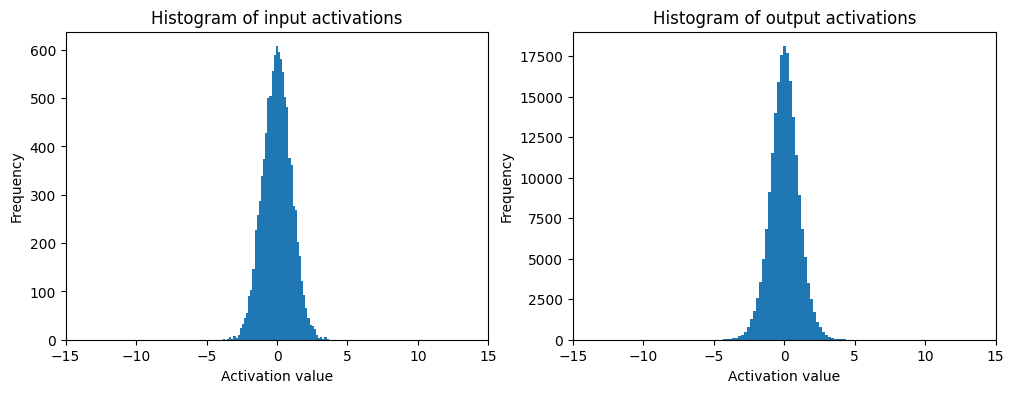

In [112]:
x = torch.randn(1000, 10)
SCALING_FACTOR = (1 / x.shape[-1])**0.5
w = torch.randn(10, 200) * SCALING_FACTOR
y = x @ w  # shape (1000, 200)
print(f"x mean = {x.mean().item():.4f}, std = {x.std().item():.4f}")
print(f"y mean = {y.mean().item():.4f}, std = {y.std().item():.4f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(x.view(-1).tolist(), 50)
plt.title("Histogram of input activations")
plt.xlabel("Activation value")
plt.ylabel("Frequency") 
plt.xlim(-15, 15)
plt.subplot(1, 2, 2)
plt.hist(y.view(-1).tolist(), 50)
plt.title("Histogram of output activations")
plt.xlabel("Activation value")
plt.ylabel("Frequency")
# use same scale for the x-axis
plt.xlim(-15, 15)
plt.show();

Since we are using `tanh()` as the activation function, the normalization factor will be $\frac{5/3}{\sqrt{n}}$ for the weights and 0 for the biases.

In [113]:
W1_scale = (5 / 3) / (N_EMBEDDINGS * CONTEXT_SIZE)**0.5

## Batch normalization

Batch normalization is a technique that normalizes the inputs to a layer by adjusting and scaling the activations. It helps to stabilize the learning process and can lead to faster convergence. The idea is to normalize the inputs to have zero mean and unit variance, which helps to mitigate the issues of vanishing gradients and exploding gradients.

In order for the output of the hidden layer to be normalized, we need to apply batch normalization. This is done by computing the mean and variance of the activations across the batch and then normalizing the activations using these statistics.

$\mu_b = \frac{1}{B} \sum_{i=1}^{B} h_i$  

$\sigma_b^2 = \frac{1}{B} \sum_{i=1}^{B} (h_i - \mu_b)^2$

$\hat{x}_i = \frac{x_i - \mu_b}{\sigma_b}$

Then to allow for the distribution to be shifted and scaled, we apply a gain and bias to the normalized activations:
$\hat{y}_i = \gamma \hat{x}_i + \beta$

Batch normalization has one unintended consequence: the output value for a given example now depends on the batch in which it is processed. This means that the model will behave differently during training and inference, which can lead to issues if not handled properly. In addition, this coupling can be seen as adding jitter (or entropy) to the example and helps prevent overfitting.

Finally, we also have to consider the effect of batch normalization when making predictions. During inference, we are likely making predictions one at a time, which means that we cannot compute the mean and variance across the batch. The solution is to compute a rolling mean and standard deviation during the training phase. The two values can then be applied at inference time.

In [114]:
params = create_model(N_EMBEDDINGS, CONTEXT_SIZE, N_HIDDEN, len(token_to_index), W2_scale=0.1, b2_scale=0.0, W1_scale=0.1, b1_scale=0.0)
# Train the model
lossi, h = train_model(params, X_train, Y_train, X_dev=None, Y_dev=None, use_batch_norm=True)

The model has 12,719 parameters.


       0/ 200,000 | Loss: 3.6222 | Learning Rate: 0.100000
  10,000/ 200,000 | Loss: 1.6282 | Learning Rate: 0.100000
  20,000/ 200,000 | Loss: 1.8343 | Learning Rate: 0.100000
  30,000/ 200,000 | Loss: 2.1400 | Learning Rate: 0.100000
  40,000/ 200,000 | Loss: 1.4409 | Learning Rate: 0.100000
  50,000/ 200,000 | Loss: 1.8635 | Learning Rate: 0.100000
  60,000/ 200,000 | Loss: 1.7364 | Learning Rate: 0.100000
  70,000/ 200,000 | Loss: 1.4071 | Learning Rate: 0.100000
  80,000/ 200,000 | Loss: 1.7045 | Learning Rate: 0.100000
  90,000/ 200,000 | Loss: 1.2645 | Learning Rate: 0.100000
 100,000/ 200,000 | Loss: 0.9600 | Learning Rate: 0.010000
 110,000/ 200,000 | Loss: 1.5586 | Learning Rate: 0.010000
 120,000/ 200,000 | Loss: 1.3129 | Learning Rate: 0.010000
 130,000/ 200,000 | Loss: 1.3933 | Learning Rate: 0.010000
 140,000/ 200,000 | Loss: 1.6565 | Learning Rate: 0.010000
 150,000/ 200,000 | Loss: 1.1850 | Learning Rate: 0.010000
 160,000/ 200,000 | Loss: 1.1128 | Learning Rate: 0.0100

The training logs show that during the initial batches, the loss is now lower than before. The optimization of the model initialization allowed us to leverage the first training steps to learn valuable signal instead of asking the model to compensate for the bad initialization.

In [115]:
def plot_loss(lossi):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 4))
    plt.plot(lossi, label='Loss (log scale)')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss (log scale)')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.grid()
    plt.show()

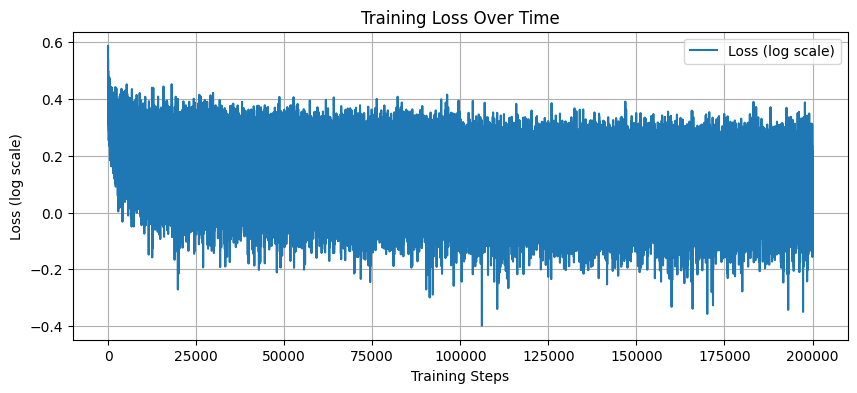

In [116]:
plot_loss(lossi)

In [117]:
@torch.no_grad()
def split_loss(split, params, use_batch_norm=False):
    """
    Compute the loss for a given split of the data.

    Args:
        split (str): The split to compute the loss for.
        params (list): The model parameters.
        use_batch_norm (bool): Whether to use batch normalization.
    """
    
    x, y = {
        "train": (X_train, Y_train),
        "dev": (X_dev, Y_dev),
        "test": (X_test, Y_test)
    }[split]

    logits = forward(params, x, use_batch_norm)

    loss = F.cross_entropy(logits, y)  # compute the cross-entropy loss

    print(f"{split.capitalize()} Loss: {loss.item():.4f}")

split_loss("train", params)
split_loss("dev", params)

Train Loss: 1.3603
Dev Loss: 1.4285


In [118]:
import re

def clean_name(name: str) -> str:
    # remove trailing "."
    name = name.rstrip(".")

    # replace "_s(_|$)" with "'s"
    name = re.sub(r"_s$", "'s", name)
    name = re.sub(r"_s_", "'s ", name)

    # replace "_" with " "
    name = name.replace("_", " ")

    # title each word
    name = " ".join(word.title() if len(word) > 1 else word for word in name.split())

    # replace "'S" with "'s"
    name = name.replace("'S", "'s")

    return name

def generate_names(params, n_names=10, use_batch_norm=False):
    """
    Generate new bird names using the trained model.
    
    Args:
        params (list[torch.Tensor]): List of model parameters including embeddings, weights, and biases.
        n_names (int): Number of names to generate. Default is 10.
        
    Returns:
        None
    """
    
    # sample new bird names from the model
    g = torch.Generator().manual_seed(56789)
    print("Generating new bird names:")
    for _ in range(n_names):
        context = [0] * CONTEXT_SIZE
        out = []
        while True:
            # Convert context to tensor and get embeddings
            context_tensor = torch.tensor(context, dtype=torch.int64).unsqueeze(0)  # shape (1, CONTEXT_SIZE)
            logits = forward(params, context_tensor, use_batch_norm)
            probs = F.softmax(logits, dim=1)  # shape (1, n_token)

            # Sample from the distribution
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()  # Get the index of the sampled token
            out.append(index_to_token[ix])  # Append the token to the output

            if ix == token_to_index[SPECIAL_TOKEN]:  # Stop if we hit the special token
                break

            # Update the context by shifting it and adding the new index 
            context = context[1:] + [ix]

        print("   "+"".join(clean_name("".join(out))))  # Print the generated bird name

generate_names(params, n_names=10)

Generating new bird names:
   Crypa Carch
   Benao Tochrees Spanes's Oophawk
   Rufous Reepos Paraked Nech Kithtin
   White Hern Stal's Flycatcheek
   Blue Phennellowbler
   Visa
   White Eye
   Chern Dove
   Pindigeon
   Sticolla


# PyTorch Implementation

In this section, we PyTorch-ify our code. The goal is to transition from our DIY implementation to a more robust and efficient one that is more similar to the available classes and functions in PyTorch.

In [204]:
g = torch.Generator().manual_seed(56789)

class Linear:

    def __init__(self, fan_in, fan_out, bias=True, generator=g):
        self.weight = torch.randn(fan_in, fan_out, generator=generator) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.momentum = momentum
        self.eps = eps
        self.training = True

        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers trained with momentum
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True) # shape (1, dim)
            xvar = x.var(0, keepdim=True, unbiased=True) # shape (1, dim)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

n_emb = 10
n_hidden = 100
vocab_size = len(token_to_index)


# model initialization
C = torch.randn((vocab_size, n_emb), generator=g)
layers = [
    Linear(n_emb * CONTEXT_SIZE, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,             n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,             n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,             n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,             n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,             vocab_size)
]


with torch.no_grad():
    # shrink confidence of last layer
    layers[-1].weight *= 0.1
    # apply tanh gain to other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3


parameters = [C] + [p for layer in layers for p in layer.parameters()]

# display number of total parameters
print(f"Total number of parameters: {sum(p.nelement() for p in parameters):,}")
for p in parameters:
    p.requires_grad = True

Total number of parameters: 47,719


In [205]:
# training parameters
max_steps = 200_000
batch_size = 32
loss_i = []
ud = []

# training block
for i in range(max_steps):

    # construct the minibatch
    idx = torch.randint(low=0, high=X_train.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = X_train[idx], Y_train[idx]

    # forward pass
    emb = C[Xb] # shape (BATCH_SIZE, CONTEXT_SIZE, N_EMBEDDINGS)
    x = emb.view(emb.shape[0], -1) # shape (BATCH_SIZE, CONTEXT_SIZE * N_EMBEDDINGS)
    for layer in layers:
        x = layer(x)

    # compute the loss
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.075 if i < 100_000 else 0.01
    for p in parameters:
        p.data -= p.grad * lr

    # log tracking
    if i % 10_000 == 0:
        print(f"{i:8,d}/{max_steps:8,d} | Loss: {loss.item():.4f} | Learning Rate: {lr:.6f}")
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append(
            [(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters]
        )

    if i == 1_000:
        break

       0/ 200,000 | Loss: 3.3723 | Learning Rate: 0.075000


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 1.25%
layer 5 (      Tanh): mean +0.01, std 0.64, saturated: 1.69%
layer 8 (      Tanh): mean +0.01, std 0.64, saturated: 1.53%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 1.03%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.28%


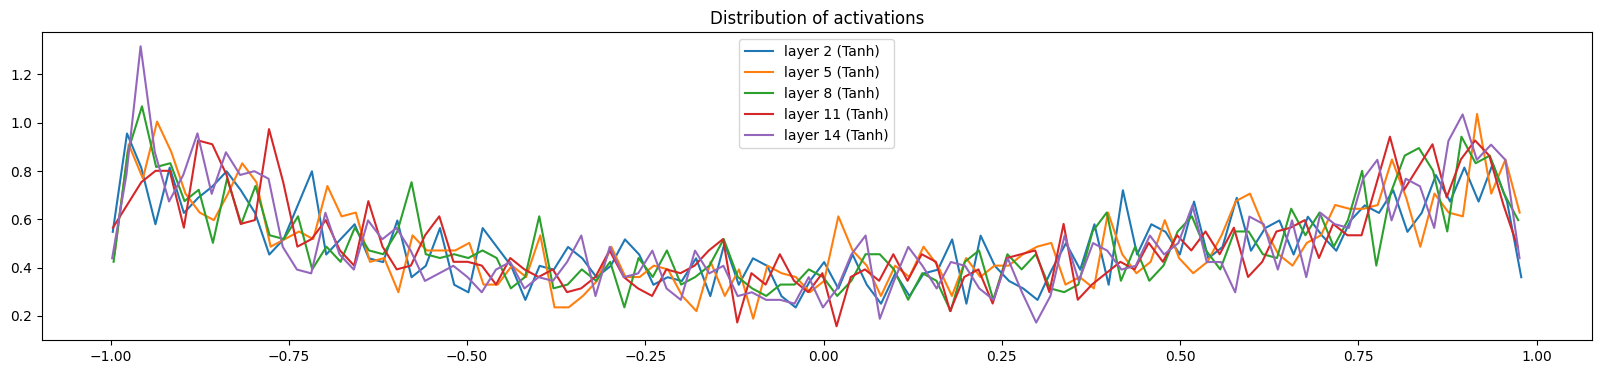

In [206]:
# visualize the content of the hidden layers
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out

        print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %2.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t > 0.97).float().mean() * 100.))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().numpy(), hy.detach().numpy())
        legends.append(f"layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Distribution of activations")
plt.show()

layer 2 (      Tanh): mean -0.000000, std 6.377883e-03
layer 5 (      Tanh): mean +0.000000, std 5.900440e-03
layer 8 (      Tanh): mean +0.000000, std 5.201767e-03
layer 11 (      Tanh): mean -0.000000, std 4.114801e-03
layer 14 (      Tanh): mean -0.000086, std 2.648591e-03


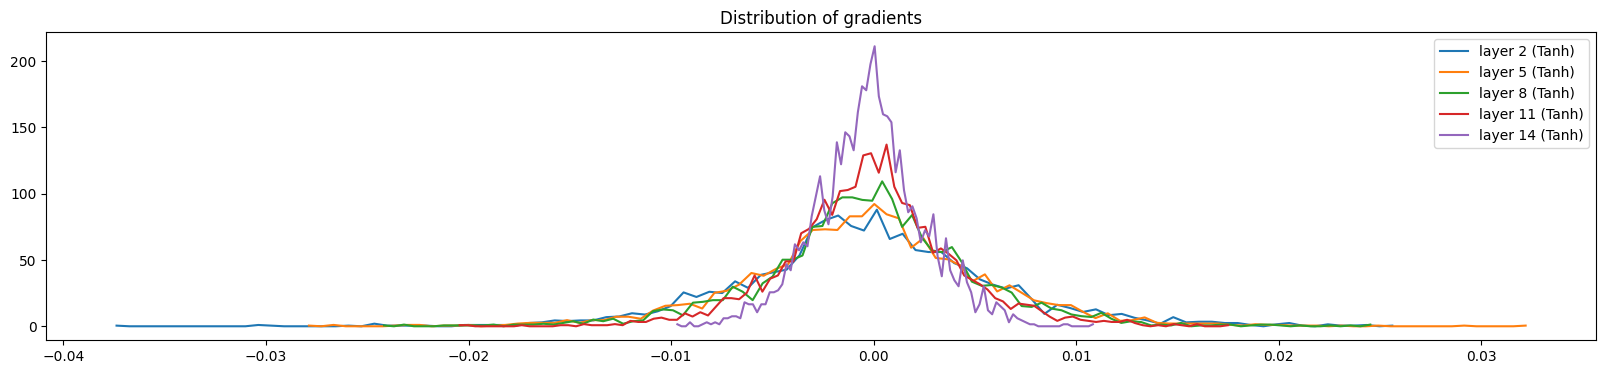

In [207]:
# visualize the content of the hidden layer gradients
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad

        print("layer %d (%10s): mean %+f, std %e" % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().numpy(), hy.detach().numpy())
        legends.append(f"layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("Distribution of gradients")
plt.show()

weight   (29, 10) | mean -0.000000 | std 1.450943e-02 | grad:data ratio 1.150493e-02
weight  (30, 100) | mean -0.000040 | std 1.690887e-02 | grad:data ratio 5.191920e-02
weight (100, 100) | mean +0.000053 | std 1.450825e-02 | grad:data ratio 8.140352e-02
weight (100, 100) | mean -0.000119 | std 1.382819e-02 | grad:data ratio 7.950932e-02
weight (100, 100) | mean -0.000179 | std 1.160649e-02 | grad:data ratio 6.387087e-02
weight (100, 100) | mean +0.000064 | std 7.540221e-03 | grad:data ratio 4.275506e-02
weight  (100, 29) | mean +0.000000 | std 2.084026e-02 | grad:data ratio 1.960166e-01


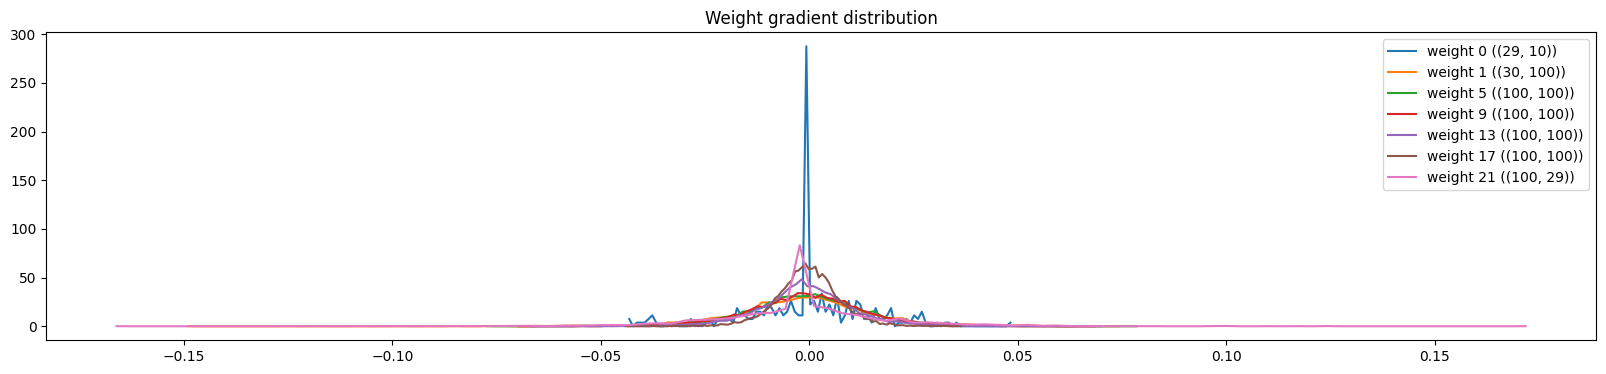

In [208]:
# visualize the content of the spread of the data over the spread of the gradient
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.abs().mean() / p.abs().mean()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach().numpy(), hy.detach().numpy())
        legends.append(f"weight {i} ({tuple(p.shape)})")

plt.legend(legends)
plt.title("Weight gradient distribution")
plt.show()

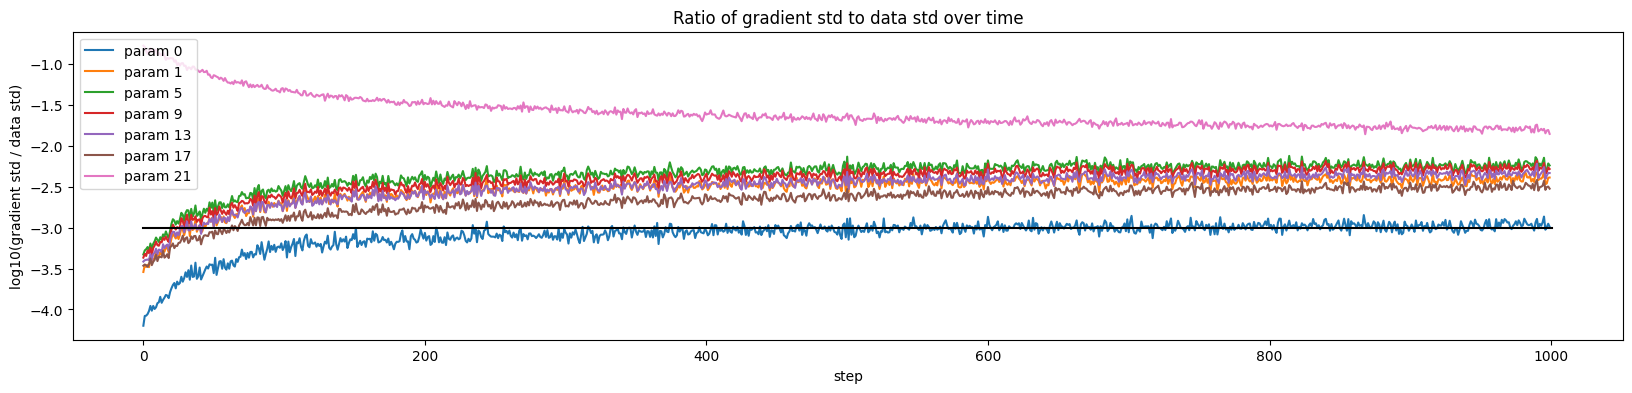

In [209]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(min(1000, len(ud)))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)
plt.xlabel("step")
plt.ylabel("log10(gradient std / data std)")
plt.title("Ratio of gradient std to data std over time");

Below, we visualize the distribution of activations and gradients of the hidden layers for a correction factor of 0.5 (versus the recommended 5/3 for tanh) and without using batch normalization.
We see that the activations are slowly condensing toward 0, while the gradients are expanding. This asymmetry is a problem because it means that the deeper layers aren't evenly activated, as most activations tend to be closer to 0.

![Activation Distribution](./part_3_figures/activation_half.png)
![Activation Distribution](./part_3_figures/gradient_half.png)


Below, we visualize the distribution of activations and gradients of the hidden layers for a correction factor of 3.0 (versus the recommended 5/3 for tanh) and without using batch normalization.
We see that the layers are saturated (i.e., most of the activations are close to -1 or 1) and the gradients are close to 0. This is a problem because it puts the model in a locked state where it cannot efficiently learn.

![Activation Distribution](./part_3_figures/activation_3.png)
![Activation Distribution](./part_3_figures/gradient_3.png)

Below, we visualize the distribution of activations and gradients of the hidden layers for a correction factor of 5/3 (versus the recommended 5/3 for tanh) and without using batch normalization.
The gradient distribution of all the different layers depicts a similar normal distribution. In addition, the gradient distributions have very similar standard deviations, showing that the gradients aren't shrinking or expanding.

![Activation Distribution](./part_3_figures/activation_53.png)
![Activation Distribution](./part_3_figures/gradient_53.png)